This Notebook is a project where we will be examining different neighborhoods of Toronto by web scraping data, creating relational dataframes, and plotting information about each neighborhood on a zoomable map of the greater Toronto area. We will then assist a new business owner in making some decisions about the direction of his new company in Toronto.

In [1]:
#Importing all necessary libraries for this noteboook
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import requests
from bs4 import BeautifulSoup
import json

!conda install -c conda-forge geopy --yes #uncoment this line if you haven't already installed this package
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# k-means from clustering stage to visualize neighborhood locations
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes #uncoment this line if you haven't already installed this package
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

First, we need to scrape the wiki page containing postal codes of Canada pertaining to Toronto. We will do this using BeautifulSoup

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
Canada_df = BeautifulSoup(source, 'lxml')
table = Canada_df.find('table', {'class': 'wikitable sortable'})
#Converts the table from the Wiki page into a usable dataframe

In [3]:
#Start building the dataframe by building a for loop to populate
table_rows = table.find_all('tr')
data = []
for row in table_rows:
    td=[]
    for t in row.find_all('td'):
        td.append(t.text.strip())
    data.append(td)
df = pd.DataFrame(data, columns=['Postalcode', 'Borough', 'Neighborhood'])
df.head(10)

,Postalcode,Borough,Neighborhood
0,None,None,None
1,M1A,Not assigned,
2,M2A,Not assigned,
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M6A,North York,"Lawrence Manor, Lawrence Heights"
7,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M8A,Not assigned,
9,M9A,Etobicoke,Islington Avenue


As we can see, there are some not assigned and missing values as well as plenty of duplicates that need cleaning up.

In [4]:
#cleaning the data
df = df[~df['Borough'].isnull()]
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.groupby(['Postalcode', 'Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index()
df['Neighborhood'].replace('Not assigned', df['Borough'], inplace=True)
df.head(10)

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [5]:
df.shape

(103, 3)

Next, we will pull the data from the geospatial coordinates CSV which will provide the latitudes and longitudes for each neighborhood of Toronto

In [6]:
path = 'https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(path)
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
df_geo.shape

(103, 3)

We will be merging this dataframe with our neighborhood dataframe, so we should make our columns match it.

In [8]:
df_geo.rename(columns={'Postal Code': 'Postalcode'}, inplace=True)
df_geo.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now merge!

In [9]:
df_neigh = df.join(df_geo.set_index('Postalcode'), on='Postalcode')
df_neigh.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


Our next task will be to map these coordinates visually using folium which is a powerful mapping library. We will also be using Nominatim to utilize its geo locator instance.

In [10]:
address = 'Toronto, ON, Canada'

#We need to get initialize an instance of the geo-locator, so we will set it to tor_explorer
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.6534817, -79.3839347.


With these coordinates giving us a large overview of the city of Toronto, we can take the coordinates of our neighborhoods and show them visually.

In [11]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neigh['Latitude'], df_neigh['Longitude'], df_neigh['Borough'], df_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto #uncomment this line to view the map of Toronto

Now we would like to use the FourSquare API to explore some of the different neighborhoods of Toronto.

In [12]:
CLIENT_ID = 'GME5MSLHY0MRGQ42F1B2330DBM2CY4B2FTCY12OBVCYERREY' #Foursquare ID
CLIENT_SECRET = 'FLADA2ESTV0UC5UIUQXOCASDUOLLLY2TDAHEFL1DBI1UCJU5' #Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GME5MSLHY0MRGQ42F1B2330DBM2CY4B2FTCY12OBVCYERREY
CLIENT_SECRET:FLADA2ESTV0UC5UIUQXOCASDUOLLLY2TDAHEFL1DBI1UCJU5


Let's find some venues on the East Side of Toronto!

In [13]:
df_neigh.loc[40, 'Neighborhood']

'East Toronto'

In [14]:
neighborhood_latitude = df_neigh.loc[40, 'Latitude'] #gives our neighborhoods latitude
neighborhood_longitude = df_neigh.loc[40, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_neigh.loc[40, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of East Toronto are 43.685347, -79.3381065.


Preparing our API call

In [15]:
LIMIT = 20 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius from the point of interest (the neighborhood we selected)
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=GME5MSLHY0MRGQ42F1B2330DBM2CY4B2FTCY12OBVCYERREY&client_secret=FLADA2ESTV0UC5UIUQXOCASDUOLLLY2TDAHEFL1DBI1UCJU5&v=20180605&ll=43.685347,-79.3381065&radius=1000&limit=20'

In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d12dd03993001b52cc7b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Greektown',
  'headerFullLocation': 'Greektown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 98,
  'suggestedBounds': {'ne': {'lat': 43.69434700900001,
    'lng': -79.32568406780766},
   'sw': {'lat': 43.67634699099999, 'lng': -79.35052893219233}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4aeb26cff964a52009bf21e3',
       'name': 'The Only Cafe',
       'location': {'address': '972 Danforth Ave',
        'crossStreet': 'at Donlands Ave',
        'lat': 43.680408988135255,
        'lng': -79.33789819168385,
        'labeledLatLngs': [{

The result we receive from our call isn't in the most readable format. Let's restructure the json file and put it into a more readable dataframe.

In [17]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#Now we clean the new data
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # normalize/flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,The Only Cafe,Beer Bar,43.680409,-79.337898
1,Serano Bakery,Bakery,43.683139,-79.346531
2,efes bar&grill,Gastropub,43.680242,-79.338346
3,Mr. Pide,Turkish Restaurant,43.679635,-79.341530
4,Motorama Restaurant,Diner,43.679849,-79.340101
5,Sakawa Coffee,Café,43.679906,-79.339807
6,Danforth Dragon Restaurant,Asian Restaurant,43.679811,-79.339838
7,The Wren,American Restaurant,43.682467,-79.328079
8,Red Rocket Coffee,Café,43.682340,-79.328530
9,Morgan's on the Danforth,Gastropub,43.682044,-79.330255


We found a beer bar!

In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

20 venues were returned by Foursquare.


Now we want to define a function that will iterate the above process across all neighborhoods in our data set. We will reset the LIMIT value in our API request to 100 to provide a broader sample set of venues in all neighborhoods.

In [19]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We will now store the results above into a new data frame, toronto_venues after we run the get request.

In [20]:
toronto_venues = getNearbyVenues(names=df_neigh['Neighborhood'],
                                   latitudes=df_neigh['Latitude'],
                                   longitudes=df_neigh['Longitude']
                                )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence P

In [21]:
print(toronto_venues.shape)
toronto_venues.head(10)

(2137, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
5,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
6,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
7,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
8,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection
9,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Eggsmart,43.767800,-79.190466,Breakfast Spot


In [22]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,57,57,57,57,57,57
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
Business reply mail Processing Centre,18,18,18,18,18,18


There are quite a few venues in each neighborhood! Some have substantially more than others. We can further analyze each neighborhood based on what type of venues it has.

In [23]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 266 uniques categories.


In [24]:
# one hot encoding. Dummy values will place a 0 into a row if there neighborhood does not contain a particular category of venue.
toronto_OH = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_OH['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_OH.columns[-1]] + list(toronto_OH.columns[:-1])
toronto_HOT = toronto_OH[fixed_columns]

print(toronto_HOT.shape)

(2137, 266)


We can get the average frequency of each venue in each neighborhood so we can begin grouping our neighborhoods.

In [25]:
toronto_grouped = toronto_HOT.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head(10)

(96, 266)


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0

In [26]:
#lets find the top five venues for each neighborhood
top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1               Skating Rink  0.25
2  Latin American Restaurant  0.25
3             Breakfast Spot  0.25
4   Mediterranean Restaurant  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place   0.2
1             Gym   0.1
2  Sandwich Place   0.1
3             Pub   0.1
4            Pool   0.1


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0.11
1                Coffee Shop  0.11
2        Fried Chicken Joint  0.05
3  Middle Eastern Restaurant  0.05
4                Gas Station  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.09
1         Coffee Shop  0.09

Let's start clustering! We will need a few more things to be able to do so.

In [27]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

print('Libraries imported.')

Libraries imported.


We should begin by taking the above dataframe, sorting it into descending order, and asking for the top 10 venues in each neighborhood instead of 5. This will give us a better view of the type of venue in each neighborhood.

In [28]:
def return_most_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

In [29]:
num_top_venues = 10 #broader sample set

indicators = ['st', 'nd', 'rd'] #(1st, 2nd, 3rd)

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1)) #(4th, 5th, 6th, etc.)

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(96, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Skating Rink,Colombian Restaurant,Comfort Food Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,College Rec Center
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Sandwich Place,Pharmacy,Pool,Pub,Dance Studio,Coffee Shop,Gym,Gas Station
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Sushi Restaurant,Bridal Shop,Middle Eastern Restaurant,Deli / Bodega,Restaurant,Pizza Place,Pharmacy,Fried Chicken Joint
3,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Grocery Store,Sushi Restaurant,Comfort Food Restaurant,Pharmacy,Pizza Place,Café


In [30]:
# set number of clusters. We run k-means on our new sorted dataframe
kclusters = 5

grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Next, we merge our sorted dataframe above with our sorted clusters and labels.

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_neigh

# merge toronto_grouped with df_neigh to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3.0,Fast Food Restaurant,Women's Store,Curling Ice,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1.0,Construction & Landscaping,Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store,Dance Studio
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Electronics Store,Intersection,Mexican Restaurant,Breakfast Spot,Medical Center,Bank,Rental Car Location,Department Store,Dessert Shop,Dim Sum Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean Restaurant,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Fried Chicken Joint,Thai Restaurant,Bakery,Athletics & Sports,Bank,Caribbean Restaurant,Gas Station,Hakka Restaurant,Dog Run,Distribution Center


Now we can call on folium again to map these new clusters to our map

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters #uncomment this line to view map

Now we can examine neighborhoods further by seeing what the most discriminating venue is per neighborhood

In [33]:
#first cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0.0,Park,Bakery,Playground,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
23,North York,0.0,Park,Bank,Convenience Store,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Dance Studio
25,North York,0.0,Park,Food & Drink Shop,Bus Stop,College Rec Center,Dance Studio,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
40,East York,0.0,Park,Coffee Shop,Convenience Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
44,Central Toronto,0.0,Park,Swim School,Bus Line,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Ethiopian Restaurant,Diner
50,Downtown Toronto,0.0,Park,Trail,Playground,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
64,Central Toronto,0.0,Trail,Jewelry Store,Sushi Restaurant,Park,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Curling Ice
72,North York,0.0,Park,Pub,Metro Station,Japanese Restaurant,Women's Store,Dim Sum Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
74,York,0.0,Park,Pool,Women's Store,Afghan Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
79,North York,0.0,Park,Construction & Landscaping,Bakery,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dance Studio


In [34]:
#second cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,1.0,Construction & Landscaping,Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store,Dance Studio
2,Scarborough,1.0,Electronics Store,Intersection,Mexican Restaurant,Breakfast Spot,Medical Center,Bank,Rental Car Location,Department Store,Dessert Shop,Dim Sum Restaurant
3,Scarborough,1.0,Coffee Shop,Korean Restaurant,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
4,Scarborough,1.0,Fried Chicken Joint,Thai Restaurant,Bakery,Athletics & Sports,Bank,Caribbean Restaurant,Gas Station,Hakka Restaurant,Dog Run,Distribution Center
6,Scarborough,1.0,Hobby Shop,Coffee Shop,Department Store,Train Station,Bus Station,Discount Store,Convenience Store,Women's Store,Deli / Bodega,Dessert Shop
7,Scarborough,1.0,Bus Line,Bakery,Ice Cream Shop,Park,Soccer Field,Intersection,Bus Station,Dim Sum Restaurant,Department Store,Dessert Shop
8,Scarborough,1.0,Motel,American Restaurant,Women's Store,Curling Ice,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
9,Scarborough,1.0,Skating Rink,College Stadium,Café,General Entertainment,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
10,Scarborough,1.0,Indian Restaurant,Vietnamese Restaurant,Pet Store,Chinese Restaurant,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
11,Scarborough,1.0,Middle Eastern Restaurant,Shopping Mall,Vietnamese Restaurant,Sandwich Place,Breakfast Spot,Auto Garage,Bakery,Dim Sum Restaurant,Deli / Bodega,Department Store


In [35]:
#third cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,2.0,Convenience Store,Playground,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
48,Central Toronto,2.0,Playground,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center


In [36]:
#fourth cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,3.0,Fast Food Restaurant,Women's Store,Curling Ice,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
80,York,3.0,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


In [37]:
#fifth cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
97,North York,4.0,Baseball Field,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


This concludes the analysis of Toronto neighborhoods. Thank you for reading thus far. In the following section, I will use many of the same skills shown to assist a new business owner decide on the type of coffee shop he should open. We will be looking at reviews from some of the more popular coffee houses in the Toronto area to start getting an idea of what coffee enthusiasts enjoy about them. Our business owner is also not a numbers person, so we will be showing him visually in a unique way!

In [38]:
#Let's go back to how we built one of our dataframes. Starting with an instance of a GeoLocator, we will begin our search and refine as we go
address = 'Toronto, ON, Canada'

#We need to get initialize an instance of the geo-locator, so we will set it to tor_explorer
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.6534817, -79.3839347.


In [39]:
CLIENT_ID = 'GME5MSLHY0MRGQ42F1B2330DBM2CY4B2FTCY12OBVCYERREY' #Foursquare ID
CLIENT_SECRET = 'FLADA2ESTV0UC5UIUQXOCASDUOLLLY2TDAHEFL1DBI1UCJU5' #Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GME5MSLHY0MRGQ42F1B2330DBM2CY4B2FTCY12OBVCYERREY
CLIENT_SECRET:FLADA2ESTV0UC5UIUQXOCASDUOLLLY2TDAHEFL1DBI1UCJU5


In [40]:
search_query = 'Coffee'
radius = 1000
print(search_query + ' .... OK!')

Coffee .... OK!


In [41]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=GME5MSLHY0MRGQ42F1B2330DBM2CY4B2FTCY12OBVCYERREY&client_secret=FLADA2ESTV0UC5UIUQXOCASDUOLLLY2TDAHEFL1DBI1UCJU5&ll=43.6534817,-79.3839347&v=20180605&query=Coffee&radius=1000&limit=100'

In [42]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d183c546f3001bfe1bf2'},
 'response': {'venues': [{'id': '59f784dd28122f14f9d5d63d',
    'name': 'HotBlack Coffee',
    'location': {'address': '245 Queen Street West',
     'crossStreet': 'at St Patrick St',
     'lat': 43.65036434800487,
     'lng': -79.38866907575726,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.65036434800487,
       'lng': -79.38866907575726}],
     'distance': 515,
     'postalCode': 'M5V 1Z4',
     'cc': 'CA',
     'neighborhood': 'Entertainment District',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['245 Queen Street West (at St Patrick St)',
      'Toronto ON M5V 1Z4',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'pr

In [43]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,59f784dd28122f14f9d5d63d,245 Queen Street West,CA,Toronto,Canada,at St Patrick St,515,"[245 Queen Street West (at St Patrick St), Tor...","[{'label': 'display', 'lat': 43.65036434800487...",43.650364,-79.388669,Entertainment District,M5V 1Z4,ON,HotBlack Coffee,v-1589039547,463001529
1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4b44fc77f964a520cc0026e3,427 University Avenue,CA,Toronto,Canada,NaN,340,"[427 University Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.65405317976302...",43.654053,-79.388090,NaN,NaN,ON,Timothy's World Coffee,v-1589039547,NaN
2,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4b0aaa8ef964a520272623e3,"483 Bay St, Bell Trinity Square",CA,Toronto,Canada,Bell Trinity Square,130,"[483 Bay St, Bell Trinity Square (Bell Trinity...","[{'label': 'display', 'lat': 43.653436, 'lng':...",43.653436,-79.382314,NaN,M5G 2C9,ON,Timothy's World Coffee,v-1589039547,NaN
3,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4fff1f96e4b042ae8acddca5,120 Lombard St,CA,Toronto,Canada,at Jarvis St,911,"[120 Lombard St (at Jarvis St), Toronto ON M5C...","[{'label': 'display', 'lat': 43.65238358726612...",43.652384,-79.372719,NaN,M5C 3H5,ON,Fahrenheit Coffee,v-1589039547,NaN
4,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",False,4baa9f6cf964a520817a3ae3,401 Bay St.,CA,Toronto,Canada,at Richmond St. W,268,"[401 Bay St. (at Richmond St. W), Toronto ON M...","[{'label': 'display', 'lat': 43.65213455850074...",43.652135,-79.381172,NaN,M5H 2Y4,ON,Timothy's World Coffee,v-1589039547,NaN


In [44]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

print(dataframe_filtered.shape)
dataframe_filtered

(50, 16)


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,HotBlack Coffee,Coffee Shop,245 Queen Street West,CA,Toronto,Canada,at St Patrick St,515,"[245 Queen Street West (at St Patrick St), Tor...","[{'label': 'display', 'lat': 43.65036434800487...",43.650364,-79.388669,Entertainment District,M5V 1Z4,ON,59f784dd28122f14f9d5d63d
1,Timothy's World Coffee,Coffee Shop,427 University Avenue,CA,Toronto,Canada,NaN,340,"[427 University Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.65405317976302...",43.654053,-79.388090,NaN,NaN,ON,4b44fc77f964a520cc0026e3
2,Timothy's World Coffee,Coffee Shop,"483 Bay St, Bell Trinity Square",CA,Toronto,Canada,Bell Trinity Square,130,"[483 Bay St, Bell Trinity Square (Bell Trinity...","[{'label': 'display', 'lat': 43.653436, 'lng':...",43.653436,-79.382314,NaN,M5G 2C9,ON,4b0aaa8ef964a520272623e3
3,Fahrenheit Coffee,Coffee Shop,120 Lombard St,CA,Toronto,Canada,at Jarvis St,911,"[120 Lombard St (at Jarvis St), Toronto ON M5C...","[{'label': 'display', 'lat': 43.65238358726612...",43.652384,-79.372719,NaN,M5C 3H5,ON,4fff1f96e4b042ae8acddca5
4,Timothy's World Coffee,Coffee Shop,401 Bay St.,CA,Toronto,Canada,at Richmond St. W,268,"[401 Bay St. (at Richmond St. W), Toronto ON M...","[{'label': 'display', 'lat': 43.65213455850074...",43.652135,-79.381172,NaN,M5H 2Y4,ON,4baa9f6cf964a520817a3ae3
5,Timothy's World Coffee,Coffee Shop,425 University Ave,CA,Toronto,Canada,Dundas,296,"[425 University Ave (Dundas), Toronto ON M5G 1...","[{'label': 'display', 'lat': 43.65427, 'lng': ...",43.654270,-79.387448,NaN,M5G 1T6,ON,53e8acc4498ee294fb100183
6,Coffee office,None,350 Bay St - 7th Floor,CA,Toronto,Canada,NaN,488,"[350 Bay St - 7th Floor, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.649498, 'lng':...",43.649498,-79.386479,NaN,NaN,ON,4baa31def964a52037523ae3
7,Timothy's World Coffee,Coffee Shop,Yonge,CA,Toronto,Canada,Dundas,481,"[Yonge (Dundas), Toronto ON M5B 2G9, Canada]","[{'label': 'display', 'lat': 43.65669995833159...",43.656700,-79.379941,NaN,M5B 2G9,ON,4ec514ec9911232436e364af
8,Balzac's Coffee,Coffee Shop,122 Bond Street,CA,Toronto,Canada,at Gould St.,618,"[122 Bond Street (at Gould St.), Toronto ON M5...","[{'label': 'display', 'lat': 43.65785440672277...",43.657854,-79.379200,NaN,M5B 1X8,ON,4fb13c20e4b011e6f93513c0
9,TEMPORARILY CLOSED-Second Cup Coffee Co. featu...,Café,"600 University Avenue, Room #202",CA,Toronto,Canada,NaN,699,"[600 University Avenue, Room #202, Toronto ON ...","[{'label': 'display', 'lat': 43.657473, 'lng':...",43.657473,-79.390637,NaN,M5G 1X5,ON,5c86b682da2e00002cf95781


Great! Now we have a dataframe of coffee shops in Toronto. We can now use the foursquare API to look further into the details of a particular coffee shop to begin collecting data for our new business owner. We will be collecting data from the tips portion of our API. Since we have a developer account, we can only recieve two tips from a location from each call... This may be tedious but will be worth the data we collect!

In [45]:
#Let's take a look at the information we can get on a trendy sounding coffee location, Fahrenheit Coffee.
venue_id = '4fff1f96e4b042ae8acddca5' # ID of Fahrenheit Coffee
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
url

'https://api.foursquare.com/v2/venues/4fff1f96e4b042ae8acddca5?client_id=GME5MSLHY0MRGQ42F1B2330DBM2CY4B2FTCY12OBVCYERREY&client_secret=FLADA2ESTV0UC5UIUQXOCASDUOLLLY2TDAHEFL1DBI1UCJU5&v=20180605'

In [46]:
#now that our api call is saved in our url variable, let's get the results as a json file
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d1cff7706a001b561d84'},
 'response': {'venue': {'id': '4fff1f96e4b042ae8acddca5',
   'name': 'Fahrenheit Coffee',
   'contact': {'phone': '6478961774',
    'formattedPhone': '(647) 896-1774',
    'twitter': 'fahrenheitto',
    'instagram': 'fahrenheitto',
    'facebook': '185428999500',
    'facebookUsername': 'fahrenheitto',
    'facebookName': 'Fahrenheit Coffee'},
   'location': {'address': '120 Lombard St',
    'crossStreet': 'at Jarvis St',
    'lat': 43.65238358726612,
    'lng': -79.37271903848271,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.65238358726612,
      'lng': -79.37271903848271}],
    'postalCode': 'M5C 3H5',
    'cc': 'CA',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['120 Lombard St (at Jarvis St)',
     'Toronto ON M5C 3H5',
     'Canada']},
   'canonicalUrl': 'https://foursquare.com/v/fahrenheit-coffee/4fff1f96e4b042ae8acddca5',
   'categories': [{'id': '4bf58dd

In [47]:
#We can specifially look at what people are saying about Fahrenheit Coffee by reading through their tips.
limit = 50 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d02340a7ea001bf66a0c'},
 'response': {'tips': {'count': 102,
   'items': [{'id': '55bc21ab498e6426258dfa1b',
     'createdAt': 1438392747,
     'text': "Tried the capuccino (on the left) - was smoother & less burnt tasting than most others I've been to but not the best. Owner was really friendly though and look at that amazing latte art! Try it out :)",
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/55bc21ab498e6426258dfa1b',
     'photo': {'id': '55bc21af498ea6bde71e52b6',
      'createdAt': 1438392751,
      'source': {'name': 'Foursquare for Android',
       'url': 'https://foursquare.com/download/#/android'},
      'prefix': 'https://fastly.4sqi.net/img/general/',
      'suffix': '/18805110_NSDrIQz5k3FLNEtC6AABalaMiXKNOV55xLr-j7bznOc.jpg',
      'width': 4128,
      'height': 2322,
      'visibility': 'public'},
     'photourl': 'https://fastly.4sqi.net/img/general/original/18805110_NSDrIQz5k3FLNEtC6AABalaMiXKNOV55xLr

Two great reviews! Let's look at another location!

In [48]:
venue_id = '4fb13c20e4b011e6f93513c0' # ID of Balzacs Coffee
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
limit = 500 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d1e59fcb92001b594d39'},
 'response': {'tips': {'count': 43,
   'items': [{'id': '5122957ce4b0320fafba1996',
     'createdAt': 1361220988,
     'text': 'Organic options, milk options, gluten free vegan treats! This place is unreal! Finally a cafe that has it all and is up with the times. Get the toasted almond mocha. So so delish.',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/5122957ce4b0320fafba1996',
     'lang': 'en',
     'likes': {'count': 2,
      'groups': [{'type': 'others',
        'count': 2,
        'items': [{'id': '41702274',
          'firstName': 'Fahim',
          'lastName': 'M',
          'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
           'suffix': '/41702274-DTC2P2UVPB31QI4O.jpg'}},
         {'id': '104122953',
          'firstName': 'Matt',
          'lastName': 'W',
          'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
           'suffix': '/104122953-5XL2LFY4DKMJDR3D.j

We will continue this process and collect data from each review to build a visually impressive display of what people say about their favorite coffee shops

In [49]:
venue_id = '563d2f2dcd10bcf27ae37c3b' # ID of another coffee shop
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
limit = 12 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d1a0c8cff2001caec355'},
 'response': {'tips': {'count': 12,
   'items': [{'id': '5667247b498e9f329d22b70e',
     'createdAt': 1449600123,
     'text': "Best coffee in Toronto! Check out their other location too Te Aro in the East, Crafted in the West and their roastery on Wagstaff! Won't disappoint",
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/5667247b498e9f329d22b70e',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agreeCount': 1,
     'disagreeCount': 0,
     'todo': {'count': 0},
     'user': {'id': '147232046',
      'firstName': 'Josh',
      'lastName': 'S',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/147232046-5AQFQ25BLWCUTDA4.jpg'}},
     'authorInteractionType': 'liked'},
    {'id': '56ebe657498e145d4494f93a',
     'createdAt': 1458300503,
     'text': 'Excellent cortado (they add half and half to the milk 😇) and good asiago scone.

In [50]:
venue_id = '57963897498e6873394a559d' # ID of another coffee shop
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
limit = 12 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d09271c428001b64c496'},
 'response': {'tips': {'count': 16,
   'items': [{'id': '588f97ca809a77756610646d',
     'createdAt': 1485805514,
     'text': 'Great baristas, very cozy, good place for working on a laptop..nice coffee:)',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/588f97ca809a77756610646d',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agreeCount': 3,
     'disagreeCount': 0,
     'todo': {'count': 0},
     'user': {'id': '6259548',
      'firstName': 'Alexander',
      'lastName': 'S',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/XIYMJPNS1IRRTN0I.jpg'}},
     'authorInteractionType': 'liked'},
    {'id': '593ac26b5c68384ad36414f2',
     'createdAt': 1497023083,
     'text': "It's more on a pricey side but quiet and cosy ☕️ They make colourful lattes with food colouring which are really fun and look great in pictures.",
     'type

In [51]:
#One last one just for good measure
venue_id = '4b44fc77f964a520cc0026e3' # ID of another coffee shop
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
limit = 12 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eb6d1dd47b43d00235fe1c2'},
 'response': {'tips': {'count': 7,
   'items': [{'id': '526aa4f711d210dc4850c2ba',
     'createdAt': 1382720759,
     'text': 'There Americanos are a delight and quite affordable! Enjoy',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/526aa4f711d210dc4850c2ba',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agreeCount': 0,
     'disagreeCount': 0,
     'todo': {'count': 0},
     'user': {'id': '13420731',
      'firstName': 'Burke',
      'lastName': 'C',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/IXCWPKPSNC5IGGBI.jpg'}}},
    {'id': '52fb82a011d24ed482104294',
     'createdAt': 1392214688,
     'text': 'Not the hippest or coziest atmosphere for catching up with others, but lots of seating for those needing study space',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/52fb82a011d24ed482104294',
 

PLEASE NOTE READER! This is a very repetitive process at this rate. The FourSquare API only allows 2 reviews per call which is very limiting. For sake of space and for your sanity of reading, I repeated this process dozens of times in another notebook to compile a single very large text document. This text document included every review found on the top coffee shops in Downtown Toronto. I then loaded the file as CSV into a pandas dataframe to be able to generate our final visual, the word cloud.

In [52]:
import csv
import pandas as pd
import os

To generate our wordcloud, we will need a few necessary packages and libraries

In [53]:
! conda install -c conda-forge/label/cf202003 wordcloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.6.0            |   py36h516909a_0         184 KB  conda-forge/label/cf202003
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge/label/cf202003
    matplotlib-base-3.1.3      |   py36hef1b27d_0         6.6 MB
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge/label/cf202003
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge/label/cf202003
    ------------------------------------------------------------
                                           Total:         9.2 MB

The following NEW packages will be INSTALLED:

    matplotlib-base: 3.1.3-py36hef1b27d_0                                
    wordcloud:       1.6.0

In [54]:
! conda install -c conda-forge matplotlib-base

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - matplotlib-base


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tk-8.6.10                  |       hed695b0_0         3.2 MB  conda-forge
    matplotlib-base-3.1.1      |   py36hfd891ef_0         6.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         9.9 MB

The following packages will be UPDATED:

    ca-certificates: 2019.11.28-hecc5488_0     conda-forge/label/cf202003 --> 2020.4.5.1-hecc5488_0     conda-forge
    certifi:         2019.11.28-py36h9f0ad1d_1 conda-forge/label/cf202003 --> 2020.4.5.1-py36h9f0ad1d_0 conda-forge
    openssl:         1.1.1e-h516909a_0         conda-forge/label/cf202003 --> 1.1.1g-h516909a_0         conda-forge
    tk:              8.6.8-hbc830

The following cell contains the tips data loaded into the notebook. The text document was saved as a CSV file so that it would be loaded into a pandas dataframe easily.

In [55]:
% matplotlib inline
import matplotlib.pyplot as plt

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-3.1.1           |           py36_0           6 KB  conda-forge

The following packages will be UPDATED:

    matplotlib: 3.0.2-py36h5429711_0 --> 3.1.1-py36_0 conda-forge


matplotlib-3.1.1     | 6 KB      | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [56]:
# The code was removed by Watson Studio for sharing.

,Reviews
0,"tasty scones, and also almond milk cappuccino ..."


In [57]:
text = df_wordcloud.Reviews[0] #The variable "text" now contains all of the tips collected from coffee shops in Downtown Toronto

In [58]:
#How many words are in the text?
text = " ".join(Reviews for Reviews in df_wordcloud.Reviews)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 9001 words in the combination of all review.


The following cell is our recipe for the our wordcloud. It will show the most frequent words larger, less frequent words smaller, and will ignore the list of stopwords 

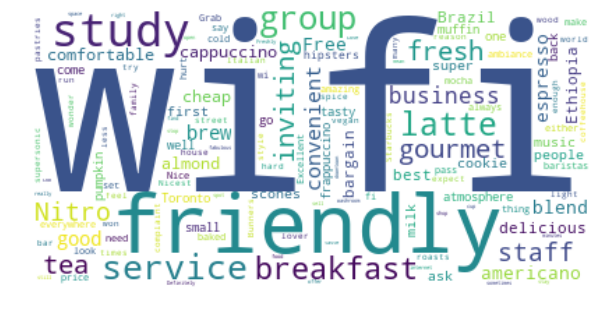

In [73]:

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "coffee", "flavor", "flavors", "great", "awesome", "place"])


# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=500, max_words=3000, collocations=False, background_color="white", random_state=1).generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From our wordcloud, it is very easy to see that the most common words are in hundreds of reviews regarding coffee houses across Toronto! The public appreciates an inviting environment that is great for business or groups, great service, friendly staff, gourmet food, wifi offered, etc.


Dear Reader,

Thank you for making it this far! I greatly appreciate you taking the time to review my work on my Capstone Project. If there is any constructive feedback you have regarding the contents of this notebook, please do not hesitate to reach out! 

Jordan